# **1. Data Loading**


In [13]:
!pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl (11.0 MB)


In [17]:
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.12.4-py3-none-any.whl.metadata (8.3 kB)
Using cached imbalanced_learn-0.12.4-py3-none-any.whl (258 kB)


In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load monitored and unmonitored data
print("Loading data...")
with open("mon_standard.pkl", 'rb') as fi:
    mon_data = pickle.load(fi)

with open("unmon_standard10_3000.pkl", 'rb') as fi:
    unmon_data = pickle.load(fi)

Loading data...


# **2. Data Preprocessing**


In [3]:
def process_data(data, label_value):
    """
    Preprocess the data to extract features and labels.
    data: The raw data (dictionary or list).
    label_value: The label for the data (e.g., 1 for monitored, -1 for unmonitored).
    return: (X1, X2, y)
    """
    X1, X2, y = [], [], []
    if isinstance(data, dict):
        for samples in data.values():
            for sample in samples:
                X1.append([abs(c) for c in sample])
                X2.append([(1 if c > 0 else -1) * 512 for c in sample])
                y.append(label_value)
    elif isinstance(data, list):
        for sample in data:
            X1.append([abs(c) for c in sample])
            X2.append([(1 if c > 0 else -1) * 512 for c in sample])
            y.append(label_value)
    return X1, X2, y

# Preprocess monitored and unmonitored data
X1_mon, X2_mon, y_mon = process_data(mon_data, label_value=1)
X1_unmon, X2_unmon, y_unmon = process_data(unmon_data, label_value=-1)

# Combine monitored and unmonitored data
X1 = X1_mon + X1_unmon
X2 = X2_mon + X2_unmon
y = y_mon + y_unmon

# **3. Feature Engineering**


In [5]:
from itertools import groupby

# Initialize a list to store newly generated features
features = []

# Compute features for each data sample
for i in range(len(X2)):
    size_seq = X2[i]
    time_seq = X1[i]
    
    # 1. Number of incoming packets
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. Total number of packets
    num_total_packets = len(size_seq)
    
    # 3. Number of outgoing packets
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. Ratio of outgoing packets to total packets
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. Ratio of incoming packets to total packets
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. Ratio of incoming packets in the first 30 packets to total incoming packets
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. Ratio of incoming packets in the first 30 packets to total packets
    incoming_first_30_all = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. Maximum number of packets in an outgoing burst
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. Ratio of outgoing packets in the first 30 packets to total packets
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 10. Ratio of outgoing packets in the first 30 packets to total outgoing packets
    outgoing_first_30_all = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 11. Number of packets in the last 5 seconds
    last_5_seconds_packets = len([size for size in size_seq[-5:] if size != 0])
    
    # 12. Standard deviation of the number of packets in outgoing bursts
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 13. Average number of packets in outgoing bursts
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 14. Total number of outgoing bursts
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 15. Total number of incoming bursts
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 16. Number of incoming packets in bursts during the first 5 seconds
    incoming_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size < 0)
    
    # 17. Number of outgoing packets in bursts during the first 5 seconds
    outgoing_burst_first_5_seconds = sum(1 for size in size_seq[:5] if size > 0)
    
    # 18. Average number of incoming packets per second
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0
    
    # 19. Ratio of incoming packets in the first 5 packets to total packets
    incoming_first_5 = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 20. Ratio of outgoing packets in the first 5 packets to total packets
    outgoing_first_5 = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0
    
    # 21. Total loading time of the website
    total_time = sum(time_seq)
    
    # 22. Ratio of incoming packets in the first 5 packets to total incoming packets
    incoming_first_5_all = sum(1 for size in size_seq[:5] if size < 0) / 5 if num_total_packets >= 5 else 0
    
    # 23. Average time interval between packets during the last 5 seconds
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 24. Ratio of outgoing packets in the first 5 packets to total outgoing packets
    outgoing_first_5_all = sum(1 for size in size_seq[:5] if size > 0) / 5 if num_total_packets >= 5 else 0

    # Append all calculated features for the current sample to the features list
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets,
        ratio_outgoing, ratio_incoming, incoming_first_30, incoming_first_30_all,
        burst_outgoing_max, outgoing_first_30, outgoing_first_30_all, last_5_seconds_packets,
        outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts, num_incoming_bursts,
        incoming_burst_first_5_seconds, outgoing_burst_first_5_seconds, incoming_per_second_avg,
        incoming_first_5, outgoing_first_5, total_time, incoming_first_5_all,
        last_5_seconds_time_intervals, outgoing_first_5_all
    ])

# 'features' contains the dataset with 24 calculated features
X = np.array(features)

# 'y' contains the labels for each sample
y = np.array(y)


# **4. Data Splitting and Upsampling**


In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

Applying SMOTE...


C:\Users\EWHA-AI\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\EWHA-AI\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [ ]:
# Data Distribution
print("Training Data Distribution After SMOTE:")
print(pd.Series(y_train_smote).value_counts())
print("Test Data Distribution:")
print(pd.Series(y_test).value_counts())

# **5. Scaling the Data**


In [9]:
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

# **6. Model training**


In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Configure the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

# Configure the Gradient Boosting model
gb_model = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.2,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

# Combine the models using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[('Random Forest', rf_model), ('Gradient Boosting', gb_model)],
    voting='soft'
)

# Train the ensemble model
print("Training the ensemble model...")
ensemble_model.fit(X_train_smote, y_train_smote)

Training the ensemble model...


VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(bootstrap=False,
                                                     max_depth=50,
                                                     n_estimators=500,
                                                     random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(learning_rate=0.2,
                                                         max_depth=20,
                                                         min_samples_split=5,
                                                         n_estimators=1000,
                                                         random_state=42))],
                 voting='soft')

# **7. Model Evaluation**


In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Evaluate the ensemble model
print("Evaluating the ensemble model...")
y_pred = ensemble_model.predict(X_test)

# Display evaluation metrics
print("\nFinal Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Evaluating the ensemble model...

Final Evaluation:
Accuracy: 0.9109090909090909
Confusion Matrix:
[[ 322  278]
 [ 114 3686]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.74      0.54      0.62       600
           1       0.93      0.97      0.95      3800

    accuracy                           0.91      4400
   macro avg       0.83      0.75      0.79      4400
weighted avg       0.90      0.91      0.90      4400



In [48]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, precision_recall_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)
precision_values, recall_values, thresholds_pr = precision_recall_curve(y_test, y_pred, pos_label=1)
pr_auc = auc(recall_values, precision_values)

print(f"True Positive Rate (TPR): {tpr[1]}")
print(f"False Positive Rate (FPR): {fpr[1]}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")
print(f"Precision-Recall AUC: {pr_auc}")

True Positive Rate (TPR): 0.97
False Positive Rate (FPR): 0.4633333333333333
Precision: 0.9298688193743693
Recall: 0.97
ROC AUC: 0.7533333333333333
Precision-Recall AUC: 0.96288895514173


# **8. Visualizing Results**


### **8.1 Data Distribution Before and After SMOTE**

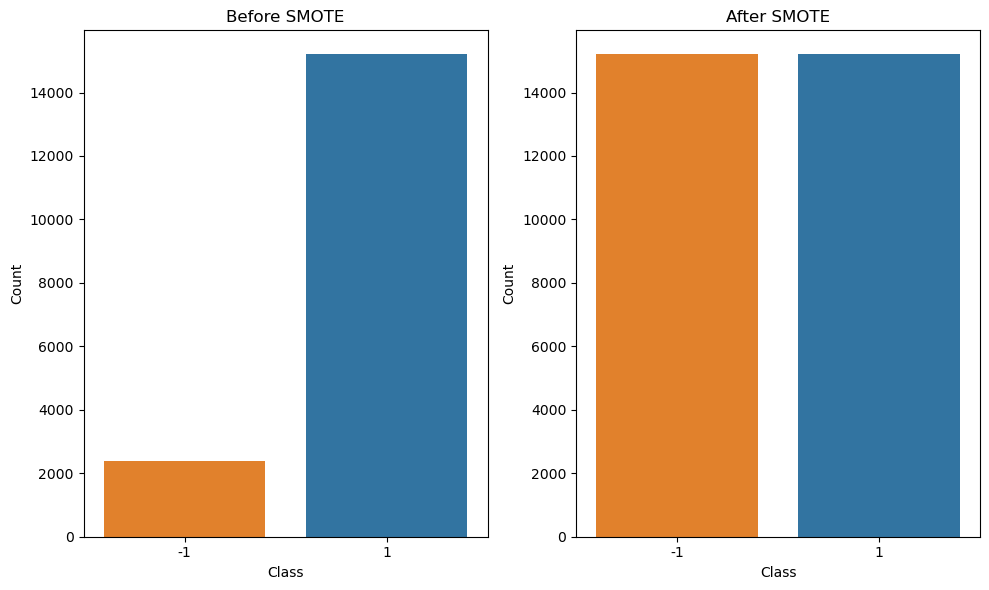

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the data distribution before and after SMOTE
plt.figure(figsize=(10, 6))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y_train, hue=y_train, palette=["#FF7F0E", "#1F77B4"], legend=False)
plt.title('Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

# After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote, hue=y_train_smote, palette=["#FF7F0E", "#1F77B4"], legend=False)
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


### **8.2 Confusion Matrix**

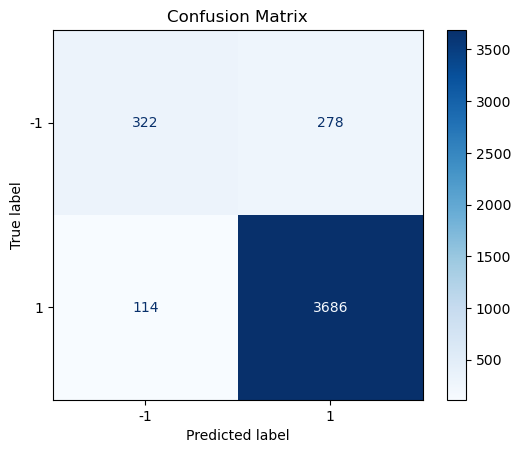

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


### **8.3 Precision-Recall Curve**

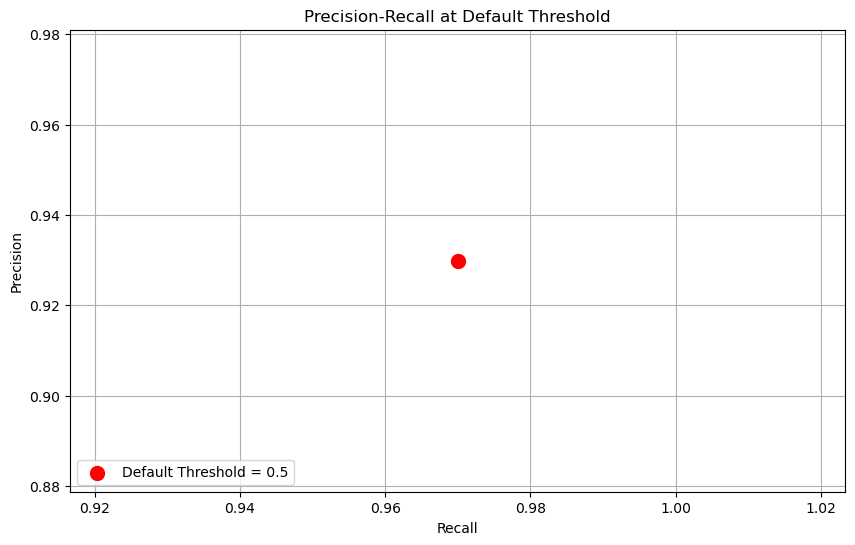

Precision at Default Threshold (0.5): 0.9299
Recall at Default Threshold (0.5): 0.9700


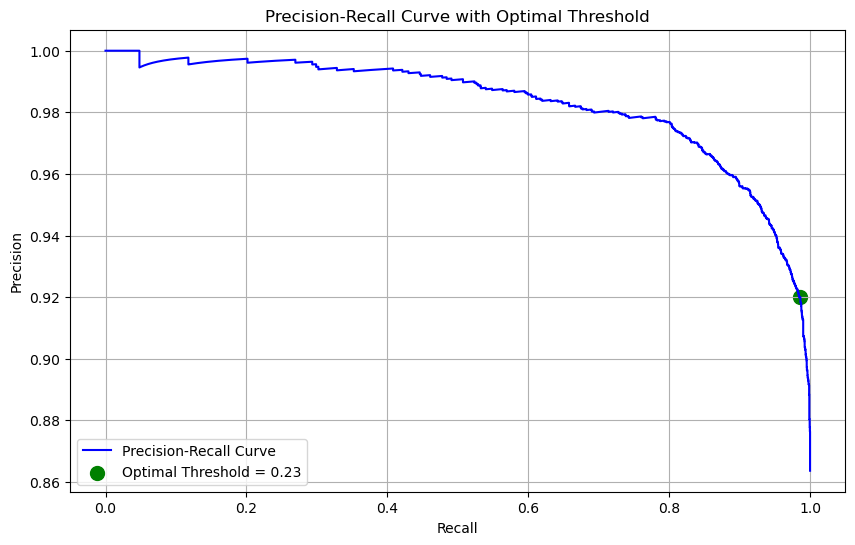

Optimal Threshold: 0.2287
Precision at Optimal Threshold: 0.9200
Recall at Optimal Threshold: 0.9863


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

# Precision-Recall (using default threshold 0.5)
def plot_default_threshold_performance(y_test, y_pred):
    """
    Visualize Precision and Recall at the default threshold of 0.5.
    :param y_test: Ground truth labels
    :param y_pred: Predicted labels using default threshold (0.5)
    """

    # Calculate Precision and Recall
    precision_default = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_default = recall_score(y_test, y_pred, pos_label=1)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(recall_default, precision_default, color="red", s=100, label="Default Threshold = 0.5")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall at Default Threshold")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

    # Output results
    print(f"Precision at Default Threshold (0.5): {precision_default:.4f}")
    print(f"Recall at Default Threshold (0.5): {recall_default:.4f}")

# Precision-Recall Curve (Optimal threshold search)
def plot_optimal_threshold_performance(y_test, y_scores):
    """
    Plot the Precision-Recall Curve and find the optimal threshold.
    :param y_test: Ground truth labels
    :param y_scores: Predicted probabilities for the positive class
    """

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # Calculate F1-Score
    optimal_idx = np.argmax(f1_scores)  # Index of the optimal threshold with maximum F1-Score

    # Precision and Recall at the optimal threshold
    optimal_threshold = thresholds[optimal_idx]
    precision_optimal, recall_optimal = precision[optimal_idx], recall[optimal_idx]

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, label="Precision-Recall Curve", color="blue")
    plt.scatter(recall_optimal, precision_optimal, color="green", s=100, label=f"Optimal Threshold = {optimal_threshold:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve with Optimal Threshold")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

    # Output results
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Precision at Optimal Threshold: {precision_optimal:.4f}")
    print(f"Recall at Optimal Threshold: {recall_optimal:.4f}")

# Compute probabilities for the positive class
y_scores_binary = ensemble_model.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class (1) only

# 1. Default model (using threshold = 0.5)
y_pred_default = ensemble_model.predict(X_test)  # Predictions using default threshold (0.5)
plot_default_threshold_performance(y_test, y_pred_default)

# 2. Threshold search (optimization)
plot_optimal_threshold_performance(y_test, y_scores_binary)


Best threshold based on F1 score: 0.25
Precision at best threshold: 0.9218
Recall at best threshold: 0.9829
F1 Score at best threshold: 0.9513


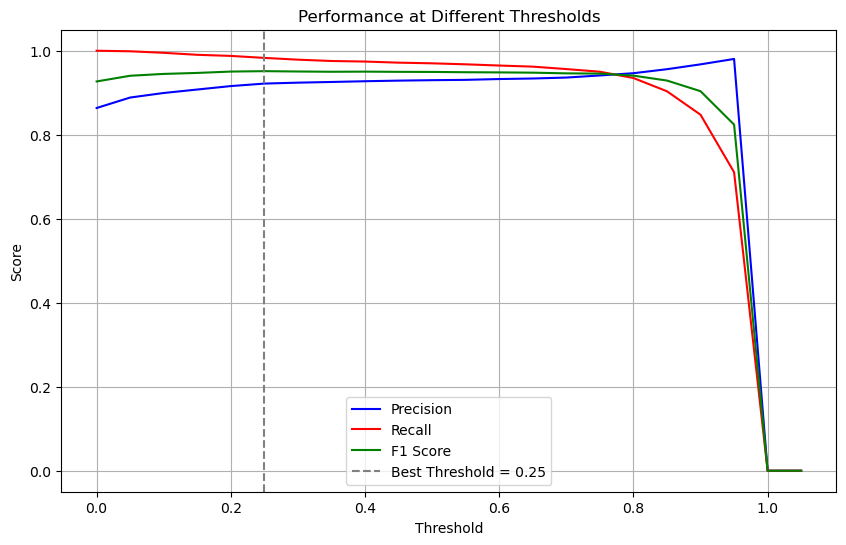

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_threshold_performance_binary(y_test, y_scores):

    thresholds = np.arange(0.0, 1.1, 0.05)  # 0부터 1까지 0.05 간격으로 Threshold 설정
    precision_vals = []
    recall_vals = []
    f1_vals = []
    
    # 각 Threshold에 대해 Precision, Recall, F1-Score 계산
    for threshold in thresholds:
        # Threshold 이상이면 1, 그렇지 않으면 0으로 분류
        y_pred = (y_scores >= threshold).astype(int)
        precision_vals.append(precision_score(y_test, y_pred, pos_label=1, zero_division=0))
        recall_vals.append(recall_score(y_test, y_pred, pos_label=1))
        f1_vals.append(f1_score(y_test, y_pred, pos_label=1))
        
    # 최적의 Threshold (F1-Score가 최대인 Threshold)
    best_threshold = thresholds[np.argmax(f1_vals)]
    print(f"Best threshold based on F1 score: {best_threshold:.2f}")
    print(f"Precision at best threshold: {precision_vals[np.argmax(f1_vals)]:.4f}")
    print(f"Recall at best threshold: {recall_vals[np.argmax(f1_vals)]:.4f}")
    print(f"F1 Score at best threshold: {f1_vals[np.argmax(f1_vals)]:.4f}")
    
    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_vals, label='Precision', color='blue')
    plt.plot(thresholds, recall_vals, label='Recall', color='red')
    plt.plot(thresholds, f1_vals, label='F1 Score', color='green')
    plt.axvline(x=best_threshold, color='gray', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance at Different Thresholds')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# 양성 클래스 확률 계산
y_scores_binary = ensemble_model.predict_proba(X_test)[:, 1]  # 양성 클래스(1)의 확률만 사용

# 클래스 레이블 변환 (-1 -> 0)
y_test_binary = np.where(y_test == -1, 0, 1)  # -1을 0으로 변환

# 시각화 함수 호출
plot_threshold_performance_binary(y_test_binary, y_scores_binary)


### **8.4 ROC Curve**

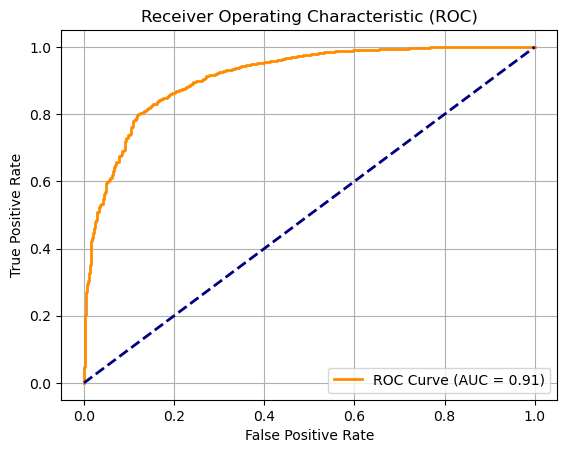

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC Curve 시각화 함수
def plot_roc_curve(y_test, y_score):
    """
    ROC Curve 시각화 함수
    :param y_test: 실제 라벨
    :param y_score: Positive 클래스의 예측 확률
    """
    # FPR, TPR 계산
    fpr, tpr, _ = roc_curve(y_test, y_score)
    # AUC 계산
    roc_auc = auc(fpr, tpr)
    
    # 그래프 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# 확률 예측 (Positive 클래스 확률)
y_test_prob = ensemble_model.predict_proba(X_test)[:, 1]

# ROC Curve 시각화
plot_roc_curve(y_test, y_test_prob)
